## Introduction and Setup 

The first step is to load in the necessary libraries for the analysis.

In [27]:
# load libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import Polygon
from rasterio.plot import show
import matplotlib.patches as mpatches
import contextily as ctx
from matplotlib.colors import BoundaryNorm, ListedColormap

# access STAC catalogs
from pystac_client import Client
import planetary_computer

from IPython.display import Image

## Data Exploration and Analysis

The first step of this analysis involves providing geographical context for the subdivison we will be investigating. First, let's plot the entirety of Phoenix for inspection. 

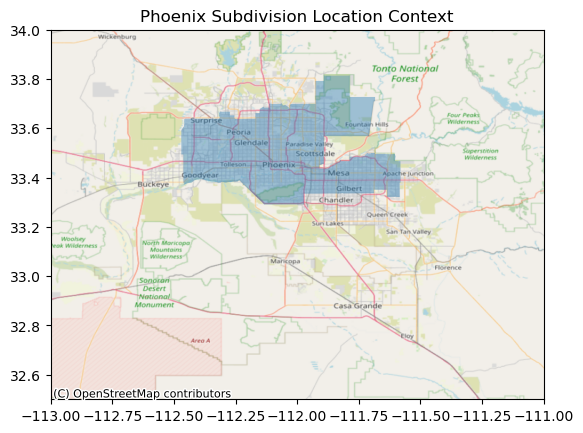

          minx      miny        maxx       maxy
21 -112.470126  33.29026 -111.580626  33.813966


In [28]:
# read in Phoenix county shapefile and rasterize
phoenix_shape_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_04_cousub_500k.zip"
phx = gpd.read_file(phoenix_shape_url)

phx = phx[phx['NAME'] == 'Phoenix']

# set axis for phoenix subdivision
ax = phx.plot(alpha = 0.4)

ax.set_xlim(-113, -111)
ax.set_ylim(32.5, 34)

# add basemap from OpenStreetMaps using Contextily
ctx.add_basemap(ax, crs = phx.crs.to_string(), source = ctx.providers.OpenStreetMap.Mapnik)

# add title 
plt.title("Phoenix Subdivision Location Context")

# display map
plt.show()

print(phx.bounds)

Utilizing OpenStreetMaps gives a Google Maps-esque feel to the visual, showing major highways and residential areas. This image provides geographical context for our analysis, with the shaded region being the area we will investigate.

This nextcode chunk initializes a connection to the STAC (SpatioTemporal Asset Catalog) server hosted by Microsoft's Planetary Computer. It uses the Client.open method from the pystac_client library, along with a specific modifier function from the planetary_computer library, to access and interact with the STAC catalog at the provided URL.

In [29]:
# access catalog through the server
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                      modifier = planetary_computer.sign_inplace, )

This next step retrieves and prints the list of collections available in the STAC catalog, transforming the fetched collections into a list format for easier viewing and manipulation. We will select the 'io-biodiversity' collection as this is what will be used in the analysis

In [30]:
# fetch the collections from the catalog
catalog.get_collections()

# print collections names
collection_list = list(catalog.get_collections())

# view the start of the collection list 
collection_list[:10]

[<CollectionClient id=daymet-annual-pr>,
 <CollectionClient id=daymet-daily-hi>,
 <CollectionClient id=3dep-seamless>,
 <CollectionClient id=3dep-lidar-dsm>,
 <CollectionClient id=fia>,
 <CollectionClient id=sentinel-1-rtc>,
 <CollectionClient id=gridmet>,
 <CollectionClient id=daymet-annual-na>,
 <CollectionClient id=daymet-monthly-na>,
 <CollectionClient id=daymet-annual-hi>]

In [31]:
# select data for analysis
bii_collection = catalog.get_child("io-biodiversity")

This next section of the code sets the temporal range for the analysis, targeting the years 2017 and 2020. It defines a geographical bounding box with specific coordinates for the region of interest and conducts a search in the STAC catalog for the 'io-biodiversity' collection for the year 2017. Following this, the code retrieves and displays the items found in the catalog search, providing a detailed view of the available data for the specified criteria.

In [32]:
# set temporal range
time_1 = "2017"
time_2 = "2020"

# create bounding box of region
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search catalog
catalog_search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_1)

In [33]:
# get catalog search items
items = catalog_search.item_collection()

# display catalog search items
items

id: bii_2017_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2017-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2017-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


The following two code chunks extracts the first item from the list of search results obtained from the STAC catalog and checks the type, ID and properties of this item to understand its data structure or format.

In [34]:
# pull first item from catalog search
first_item = items[0]

# check item type
type(first_item)

pystac.item.Item

In [35]:
# display item id and properties
print("First item ID:", first_item.id)

first_item.properties

First item ID: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z'}

The next bit of code displays a rendered preview image of the geographical area related to the first item in the catalog search results, using the image URL from the 'rendered_preview' asset of the item, with the image width set to 600 pixels.

In [36]:
# display preview of area
Image(url=first_item.assets['rendered_preview'].href, width = 600)

This next code chunk parses through the keys of the assets dictionary of the first item retrieved from the catalog search.

In [37]:
for key in first_item.assets.keys():
    print(key, "--", first_item.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


This next code chunk opens a raster dataset from the URL specified in the 'data' asset of the first item retrieved from the catalog search. It uses the rioxr.open_rasterio function to read the raster data. The resulting array_rast object contains the raster data which will be used for further analysis.

In [38]:
array_rast = rioxr.open_rasterio(first_item.assets['data'].href)

array_rast

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## Clipping

Now, let's move on to importing the Phoenix county shapefile for visualization purposes. The following analysis reads in the shapefile, converts to proper CRS, and clips the array raster to the Phoenix region that we want to focus on.

<Axes: >

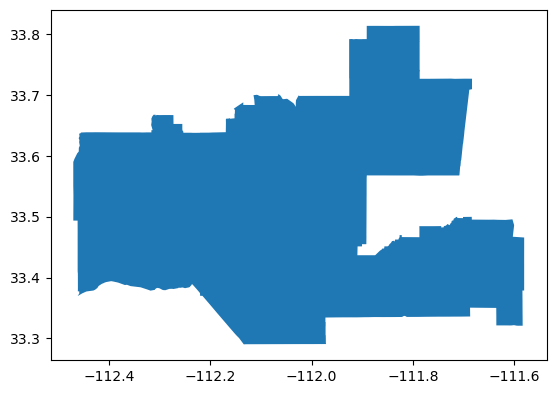

In [39]:
# plot Phoenix shapefile
phx.plot()

In [40]:
# convert CRS of Phoenix to match array raster
phx = phx.to_crs(array_rast.rio.crs)

# confirm that CRS are matching
print(array_rast.rio.crs == phx.crs)

True


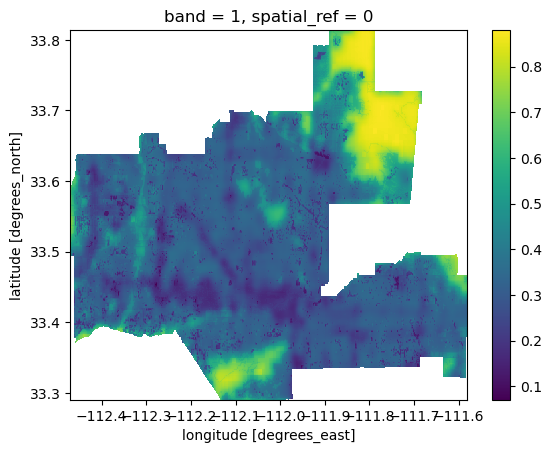

In [41]:
# clip the array raster to the Phoenix region
phx_clipped = array_rast.rio.clip(phx.geometry)

# display clipped Phoenix region
phx_clipped.plot()

This next step of the analysis filters for areas in Phoenix where BII is greater than 0.75, then calculates the percentage of the total county that is above this value. 

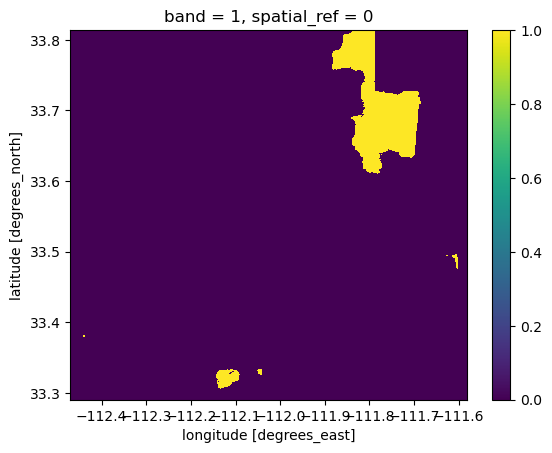

In [42]:
# find areas where BII is greater than 0.75
phx_clipped_75 = phx_clipped > 0.75

# plot filtered area
phx_clipped_75.plot()

In [43]:
# calculate the percentage of the area where BII is greater than 0.75
pct_above = phx_clipped_75.sum()/phx_clipped.size * 100

print(f"Percent of area with BII >= 0.75", pct_above)

Percent of area with BII >= 0.75 <xarray.DataArray ()>
array(4.18299634)
Coordinates:
    spatial_ref  int64 0


## Difference Function

The calc_pct function in this code chunk analyzes biodiversity changes across years, focusing on 2017 to 2020. It begins by defining the bounding box and searching the STAC catalog for the 'io-biodiversity' collection specific to the input year. After retrieving and converting the first item from the catalog into a raster array, the function processes a Phoenix county shapefile to align with the raster data. It then clips the data to the Phoenix region, identifies areas where the Biodiversity Intactness Index (BII) is greater than 0.75, calculates the percentage of such areas, and returns both the percentage and the filtered raster data. The function is then implemented to calculate the BII area difference from 2017 to 2020 and a visual is plotted of this difference in area. This allows for a year to year relationship to be investigated.

In [44]:
# create function to compare difference from 2017 to 2020

def calc_pct(time_1):
    # create bounding box of region
    bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

    # search catalog
    catalog_search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_1)
    
    # get catalog search items
    items = catalog_search.item_collection()
    
    # select first item from catalog 
    first_item = items[0]
    
    # convert to raster array
    array_rast = rioxr.open_rasterio(first_item.assets['data'].href)
    
    # read in Phoenix county shapefile and rasterize
    phoenix_shape_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_04_cousub_500k.zip"
    phx = gpd.read_file(phoenix_shape_url)

    phx = phx[phx['NAME'] == 'Phoenix']
    
    # convert CRS to match raster array
    phx = phx.to_crs(array_rast.rio.crs)
    
    # clip data to just Phoenix region
    phx_clipped = array_rast.rio.clip(phx.geometry)
    
    # find area that BII is greater than 0.75
    phx_clipped_above75 = phx_clipped > 0.75
    
    # calculate percentage of total area
    pct = float(phx_clipped_above75.sum() / phx_clipped.size * 100)
    return phx_clipped_above75, pct
    


Sweet, now that we've made this function let's test it with the data we have so far. This next code chunks calculates implements the calc_pct function we just made, which will output the change in BII of at least 0.75 from 2017 to 2020. As this function is tested, both maps will be display that show where BII is greater than 0.75, then a combined map that shows the differences between the two since they relate to the respective years we are analyzing. 

In [45]:
# testing the function, recall from earlier we have stored the years as time_1 and time_2
testing_2020 = calc_pct(time_2)
testing_2017 = calc_pct(time_1)

print("Percentage of Phoenix subdivision with a BII of at least 0.75 in 2020:", testing_2020[1])
print("Percentage of Phoenix subdivision with a BII of at least 0.75 in 2017:", testing_2017[1])

diff = testing_2020[1] - testing_2017[1]
print("BII > 0.75 lost from 2017 to 2020:", diff)

Percentage of Phoenix subdivision with a BII of at least 0.75 in 2020: 3.811182147374257
Percentage of Phoenix subdivision with a BII of at least 0.75 in 2017: 4.182996344231336
BII > 0.75 lost from 2017 to 2020: -0.37181419685707917


This resulting difference of approximately -0.3718 gives the percent change of areas in the region with a BII of at least 0.75 in 2017 that were lost by 2020. The value is negative since it is subtracting 2020 from 2017, and there is that much less of area that has BII greater than 0.75 in 2020 than 2017. 

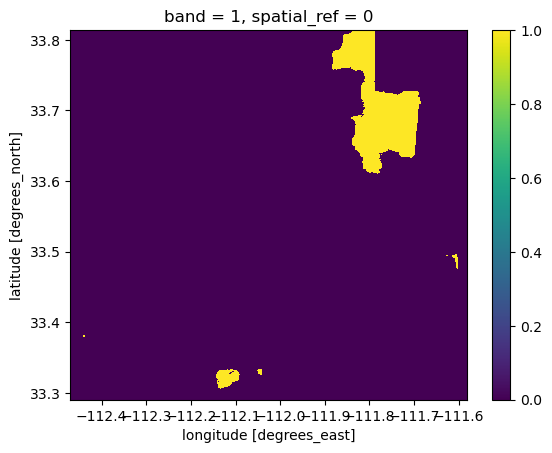

In [46]:
# visualizing BII index in 2017
bii_index_2017 = testing_2017[0]
bii_index_2017.plot()

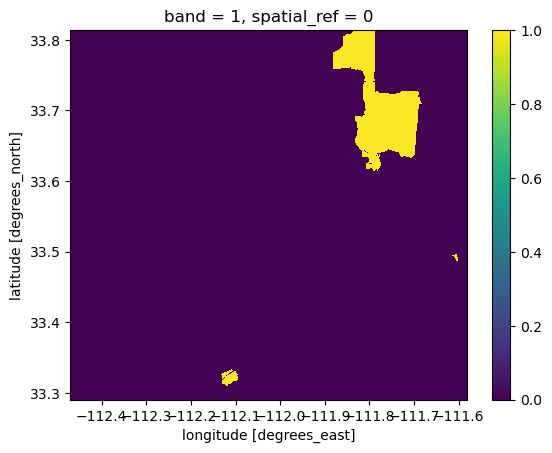

In [47]:
# visualizing BII index in 2020
bii_index_2020 = testing_2020[0]
bii_index_2020.plot()

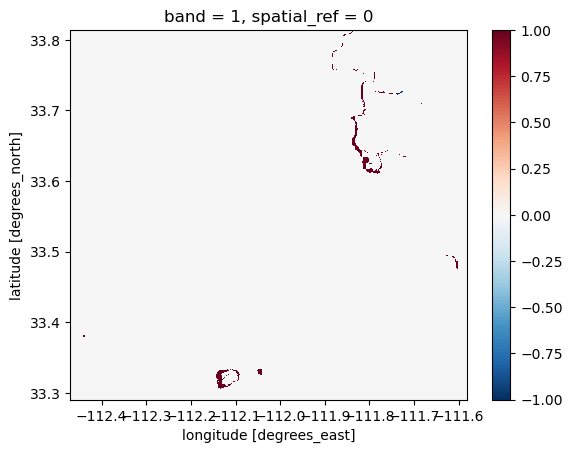

In [48]:
# plot the difference of the two maps above
bii_index_2017_int = bii_index_2017[0].astype(int)
bii_index_2020_int = bii_index_2020[0].astype(int)

diff_area = bii_index_2017_int - bii_index_2020_int

diff_area.plot()

Areas highlighted in this visual show places that saw changes in BII from 2017 to 2020 at or more than our defined significance level of 0.75

## Reclassification

This next code chunk is reclassifying a matrix, diff_area, to simplify its data representation for further analysis. It first converts diff_area to a floating-point type, creating diff_area_nan. Then, it iterates through each element of diff_area_nan, checking its value. If an element's value is zero, it is replaced with NaN (not a number), essentially marking it as a non-significant or empty data point. For all other elements (i.e., those not equal to zero), the value is set to 1, indicating significant or non-empty data points. This reclassification process effectively binarizes the matrix.

In [49]:
# reclassification matrix
classification = [-np.inf, 0, 1, np.inf]
diff_area_nan = diff_area.astype(float)

for i in range(diff_area_nan.shape[0]):
    for j in range(diff_area_nan.shape[1]):
        if diff_area_nan[i,j].item() == 0:
            diff_area_nan[i,j] = np.nan
        else:
            diff_area_nan[i,j] = 1

In [50]:
# check that values of reclassification matrix are either nan or 1
np.unique(diff_area_nan)

array([ 1., nan])

Sweet, the values in the matrix are what we want - either 1 or nan.

## Final Result

This final code chunk generates a visualization to represent the difference in the Biodiversity Intactness Index (BII) in the Phoenix area between 2017 and 2020. Initially, it sets up color options for the plot and defines a colormap and a normalization based on predefined bins. The phx_clipped data, representing the Phoenix region, is plotted first. Then, the diff_area_nan data, which shows the difference in BII greater than 0.75 between the two years, is plotted on top with a specific colormap and normalization. A custom patch (in black) is created to represent areas with significant BII difference, and this is added to the plot legend. Finally, the axis is turned off for a cleaner look, and the plot is displayed for inspection.

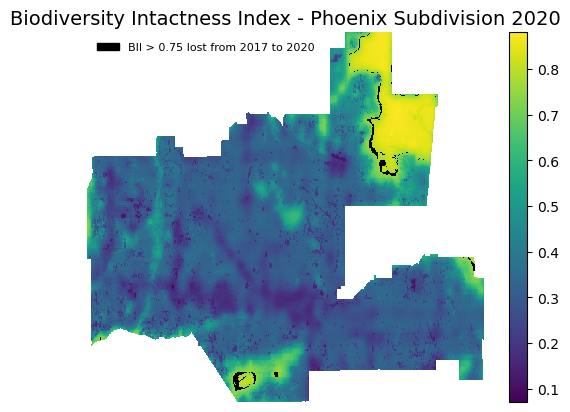

In [51]:
color_options = ['red', 'blue']
bins = [-100,0,100]
cmap = ListedColormap(color_options)
norm = BoundaryNorm(bins, len(color_options))

fig, ax = plt.subplots()

phx_clipped.plot(ax=ax, label = "Phoenix Clipped")

diff_area_nan.plot(ax=ax, cmap = 'inferno', norm=norm, add_colorbar=False)
diff_area_patch = mpatches.Patch(color='black', label='BII > 0.75 lost from 2017 to 2020')

ax.set_axis_off()

ax.legend(handles = [diff_area_patch], loc = 'upper left', frameon = False, fontsize = 8)

ax.set_title("Biodiversity Intactness Index - Phoenix Subdivision 2020", fontsize = 14)

image_path = 'images/bii_phx_change.png'
plt.savefig(image_path, bbox_inches = 'tight')

plt.show()                